<a href="https://colab.research.google.com/github/Athri-Kumar/DSCI_572_sup-learn-2/blob/master/EE599_ML_Systems_HW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW6 EE599 Systems for Machine Learning, Fall 2023
University of Southern California

Instructors: Arash Saifhashemi, Murali Annavaram

In this homework assignment, we're going to implement DP-SGD for neural networks! Recall from the class that classical ML models possessed convenient properties such as Convexity and L-Lipschitzness which make the DP analysis easy. However, modern neural networks, like the one we'll be working with, does not have these properties. Thus, we need to modify the training algorithm, gradient descent, so that the trained model is DP.

## Prerequisites:

Set the runtime type to GPU. (Runtime -> Change Runtime Type)

## Mount Google Drive

Create a folder named `HW6` under `ML_Systems` in your Google drive.

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

import sys, os

data_dir = "/content/drive/MyDrive/ML_Systems/HW6/data"

Mounted at /content/drive


## Initial Setup

This section imports all required packages from PyTorch.

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import copy

torch.manual_seed(0)

**Reminder:** set the runtime type to "GPU", or your code will run much more slowly on a CPU.

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA")
else:
    device = torch.device("cpu")


CUDA


Define model architecture and prepare dataset, which are the same as the previous homework.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Define the layers of the neural network architecture

        # First convolutional layer: 3 input channels, 6 output channels, kernel size 5x5
        self.conv1 = nn.Conv2d(3, 6, 5, bias=False)

        # Max pooling layer with kernel size 2x2 and stride 2
        self.pool = nn.MaxPool2d(2, 2)

        # Second convolutional layer: 6 input channels, 16 output channels, kernel size 5x5
        self.conv2 = nn.Conv2d(6, 16, 5, bias=False)

        # Fully connected (dense) layers

        # First fully connected layer: 16*5*5 input features, 120 output features
        self.fc1 = nn.Linear(16 * 5 * 5, 120, bias=False)

        # Second fully connected layer: 120 input features, 84 output features
        self.fc2 = nn.Linear(120, 84, bias=False)

        # Third fully connected layer: 84 input features, 10 output features (for classification)
        self.fc3 = nn.Linear(84, 10, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Forward pass through the neural network

        # Apply first convolutional layer, followed by ReLU activation and max pooling
        x = self.pool(F.relu(self.conv1(x)))

        # Apply second convolutional layer, followed by ReLU activation and max pooling
        x = self.pool(F.relu(self.conv2(x)))

        # The output from the convolutional and pooling layers is in the form of a
        # 3D tensor (height, width, depth or channels).
        # To feed this tensor into a fully connected layer,
        # it needs to be flattened into a 1D tensor.
        # Reshape tensor for fully connected layers
        # A2D tensor with a shape of [batch_size, 16 * 5 * 5].
        x = x.view(-1, 16 * 5 * 5)

        # Apply first fully connected layer, followed by ReLU activation
        x = F.relu(self.fc1(x))

        # Apply second fully connected layer, followed by ReLU activation
        x = F.relu(self.fc2(x))

        # Apply third fully connected layer (output layer)
        x = self.fc3(x)

        return x

In [ ]:
# A function to evaluate the performance of a given neural network model
# using a test dataset.
# It calculates the accuracy of the model's predictions on the test data.
def calculate_accuracy(
    model: nn.Module, dataloader: DataLoader, max_samples=None
) -> float:
    correct_predictions = 0  # Initialize the count of correctly predicted samples
    total_samples = 0  # Initialize the count of total samples
    inference_count = 0  # Initialize the count of inferences made

    with torch.no_grad():  # Disable gradient calculation for inference
        for batch_data in dataloader:
            images, labels = batch_data  # Separate images and labels from the batch

            images = images.to(device)  # Move images to the specified device
            labels = labels.to(device)  # Move labels to the specified device

            outputs = model(images)  # Forward pass to get model predictions
            _, predicted = torch.max(outputs.data, 1)  # Get predicted class indices

            total_samples += labels.size(0)  # Increment the total count of samples
            correct_predictions += (
                (predicted == labels).sum().item()
            )  # Count correct predictions

            if (
                max_samples
            ):  # Check if a maximum number of samples for testing is specified
                inference_count += images.shape[
                    0
                ]  # Increment the count of inferences made
                if (
                    inference_count > max_samples
                ):  # Stop testing if maximum samples reached
                    break

    accuracy = (
        100 * correct_predictions / total_samples
    )  # Calculate the accuracy as a percentage
    return accuracy

## DP Hyperparamters
Here is where we will defined the different hyperparameters needed for DP-SGD.
* $N = 2048$: Number of datapoints we are using. Since DP-SGD takes extremely long to run, we will only use a subset of the total CIFAR-10 dataset
* $C = 1.0$: This is the clipping threshold. If $||∇L(x, y)||_{2} > C$ then we divide by $||∇L(x, y)||_{2}$.
* $E = 20$: Number of epochs to run DP-SGD
* $q = batch\_size / N$: This is the sample probability. Since we are grouping the dataset into batches, each batch can be thought of as being sampled.
* $T = \frac{E}{q}$: number of iterations. This is more of an internal value used to calculate the DP parameter values, because DP-SGD is measured in terms of iterations, not epochs. But we can convert from Epochs to iterations.
* $\sigma$: The noise multiplier used to add noise to the gradients. As $\sigma$ gets larger, the privacy guarantee improves but the variance of the noise increases, which can reduce the accuracy or utility. The choice of $\sigma$ is often related to the desired $\varepsilon$ value; achieving a lower
$\varepsilon$ (stronger privacy) typically requires a higher
$\sigma$.

* $\delta = 10^{-5}$: This is the probability of failure. We will set this to a default value.
* $\varepsilon = \frac{q * \sqrt{T * \log(1 / \delta)}}{\sigma}$: the privacy loss, which is a function of the other hyperparameters. It quantifies the strength of the privacy guarantee. In DP, $\varepsilon$ is used to define the level of indistinguishability that the algorithm ensures between outputs generated from datasets that differ by a single element. A smaller value means  a stronger privacy guarantee, meaning the outputs of the algorithm are more similar (indistinguishable) regardless of whether any individual's data is included or excluded from the dataset.
However, a smaller value usually means more noise must be added to the data, which can degrade the utility or accuracy of the algorithm's output.


In [ ]:
batch_size = 32
N = 2048
C = 1.0
E = 20
q = batch_size / N
T = E / q
delta = 1e-5

In [ ]:
# Define the mean values and standard deviation values for normalization
mean_values = (0.5, 0.5, 0.5)  # Mean values for red, green, and blue channels
std_values = (
    0.5,
    0.5,
    0.5,
)  # Standard deviation values for red, green, and blue channels

# Define the transformation pipeline
transform = transforms.Compose(
    [
        transforms.ToTensor(),  # Convert images to tensors
        transforms.Normalize(mean_values, std_values),  # Normalize tensor values
    ]
)

# Load the CIFAR10 training dataset and apply the defined transformations
trainset = torchvision.datasets.CIFAR10(
    root=data_dir, train=True, download=True, transform=transform
)

trainsubset = torch.utils.data.Subset(trainset, torch.arange(N))

# Create a DataLoader to efficiently load and process training data in batches
trainloader = torch.utils.data.DataLoader(
    trainsubset, batch_size=batch_size, shuffle=False, num_workers=2
)

100%|██████████| 170498071/170498071 [00:01<00:00, 103468704.15it/s]


Extracting /content/drive/MyDrive/ML_Systems/HW6/data/cifar-10-python.tar.gz to /content/drive/MyDrive/ML_Systems/HW6/data


## Non-Private Training with SGD

In [ ]:

def SGD(model, dataloader, lr):
    # Define the loss criterion and optimizer
    criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
    optimizer = optim.SGD(model.parameters(), lr=lr)

    # Loop over the dataset for multiple epochs
    for epoch in range(E):
        running_loss = 0.0

        for batch in dataloader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            output = model(inputs)
            loss = criterion(output, labels)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            running_loss += loss

        print(f"Epoch {epoch+1} loss: {running_loss/len(dataloader):.4f}")

    print("Finished Training")  # Training loop is complete

# Create model and start training
net = Net().to(device)
SGD(net, trainloader, lr=0.05)

score = calculate_accuracy(net, trainloader)
print('Accuracy of the network on the train images: {}%'.format(score))

Epoch 1 loss: 2.3020
Epoch 2 loss: 2.3006
Epoch 3 loss: 2.2974
Epoch 4 loss: 2.2823
Epoch 5 loss: 2.2018
Epoch 6 loss: 2.0946
Epoch 7 loss: 1.9965
Epoch 8 loss: 1.9134
Epoch 9 loss: 1.8428
Epoch 10 loss: 1.7821
Epoch 11 loss: 1.7264
Epoch 12 loss: 1.6725
Epoch 13 loss: 1.6219
Epoch 14 loss: 1.5748
Epoch 15 loss: 1.5296
Epoch 16 loss: 1.4867
Epoch 17 loss: 1.4442
Epoch 18 loss: 1.4023
Epoch 19 loss: 1.3477
Epoch 20 loss: 1.2954
Finished Training
Accuracy of the network on the train images: 52.001953125%


## Q1: Privacy-Aware Training with DP-SGD
TODO: Change the naive SGD function to make it become differentially private. Please refer to the original [paper](https://arxiv.org/pdf/1607.00133.pdf) for DP-SGD alogrithm.

Note that we have removed the pytorch optimizer. Instead, we'll be implementing the optimzer functionality ourselves.

We set $\sigma = 0.05$ and $lr = 0.05$. Note that this training loop has not converged to the optimal weights due to insufficient training epochs, but for simplicity, we stop training after 20 epochs. In practice, to get the optimal accuracy for DP-SGD, we need to run significantly more epochs than naive SGD.

In [ ]:
from torch.nn.utils import clip_grad_norm_

def DPSGD(model, dataloader, sigma, lr):
    # Define the loss criterion and optimizer
    criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification

    # Loop over the dataset for multiple epochs
    for epoch in range(E):
        running_loss = 0.0

        for batch in dataloader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            for param in model.parameters():
                param.accumulated_grads = torch.zeros_like(param)

            # Iterate over each input sample and its corresponding label sample
            per_batch_loss = 0.0
            for input_sample, label_sample in zip(inputs, labels):
                input_sample = input_sample.unsqueeze(0)
                label_sample = label_sample.unsqueeze(0)

                # TODO: Compute gradients per sample
                model.zero_grad()
                output = model(input_sample)
                loss = criterion(output, label_sample)
                loss.backward()

                # TODO: Accumulate per_sample_loss to per_batch_loss for debugging purpose
                per_batch_loss = per_batch_loss + loss.item()

                with torch.no_grad():
                    # TODO: Clip gradients and add noise, then accumulate gradients
                    for param in model.parameters():
                      if param.grad is not None:
                          clip_grad_norm_(param, max_norm=sigma)
                          whiteN = torch.normal(mean=0.0, std=sigma, size=param.grad.size()).to(device)
                          param.accumulated_grads += param.grad + whiteN

                # TODO: Clear gradients
                for param in model.parameters():
                  param.grad.zero_()

            # TODO: Average per_batch_loss and accumulate it to running_loss for debug purpose
            running_loss += per_batch_loss / len(inputs)

            with torch.no_grad():
                # TODO: Averge accumulated gradients and update parameters
                # Please use param.copy_() to set new param
                for param in model.parameters():
                  updated_param = param.accumulated_grads / len(dataloader)
                  param.copy_(updated_param)  # Update parameters using accumulated gradients
                  param.accumulated_grads.zero_()  # Reset accumulated gradients

        print(f"Epoch {epoch+1} loss: {running_loss/len(dataloader):.4f}")

    print("Finished Training")  # Training loop is complete

# Create model and start training
net = Net().to(device)
DPSGD(net, trainloader, sigma=0.05, lr=0.05)

score = calculate_accuracy(net, trainloader)
print('Accuracy of the network on the train images: {}%'.format(score))

Epoch 1 loss: 2.3026
Epoch 2 loss: 2.3026
Epoch 3 loss: 2.3026
Epoch 4 loss: 2.3026
Epoch 5 loss: 2.3026
Epoch 6 loss: 2.3026
Epoch 7 loss: 2.3026
Epoch 8 loss: 2.3026
Epoch 9 loss: 2.3026
Epoch 10 loss: 2.3026
Epoch 11 loss: 2.3026
Epoch 12 loss: 2.3026
Epoch 13 loss: 2.3026
Epoch 14 loss: 2.3026
Epoch 15 loss: 2.3026
Epoch 16 loss: 2.3026
Epoch 17 loss: 2.3026
Epoch 18 loss: 2.3026
Epoch 19 loss: 2.3026
Epoch 20 loss: 2.3026
Finished Training
Accuracy of the network on the train images: 8.544921875%


## Q2: Privacy and utility trade-off

TODO: Plot how $\epsilon$ changes as $\sigma$ is increasing from 0.01 to 1. For the rest of the DP-SGD hyperparameters, use the default values defined above.

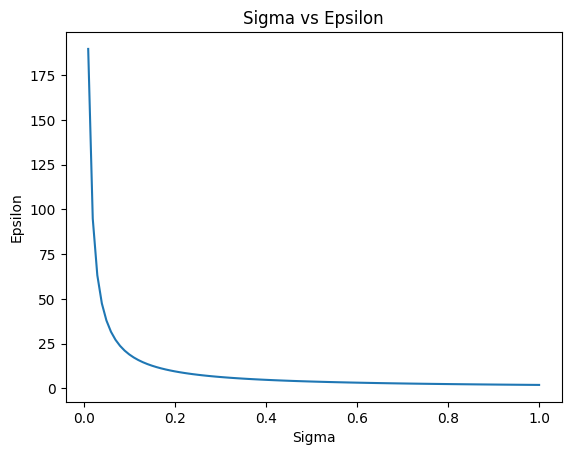

In [ ]:
sigma_values = np.linspace(0.01, 1, 100)
epsilon_values = []

# TODO: calculate epsilon values for each sigma value based on the formula
for sig in sigma_values:
  epsilon = q*np.sqrt(T*np.log(1/delta))/sig
  epsilon_values.append(epsilon)

# Plot sigma vs epsilon
plt.plot(sigma_values, epsilon_values)
plt.xlabel("Sigma")
plt.ylabel("Epsilon")
plt.title("Sigma vs Epsilon")
plt.show()

TODO: Run DP-SGD again with $\sigma=0.1$ and compare accuracy with the previous experiment.

In [ ]:
# Create model and start training
net = Net().to(device)
DPSGD(net, trainloader, sigma=0.1, lr=0.05)

score = calculate_accuracy(net, trainloader)
print('Accuracy of the network on the train images: {}%'.format(score))

Epoch 1 loss: 2.3026
Epoch 2 loss: 2.3026
Epoch 3 loss: 2.3026
Epoch 4 loss: 2.3026
Epoch 5 loss: 2.3026
Epoch 6 loss: 2.3026
Epoch 7 loss: 2.3026
Epoch 8 loss: 2.3026
Epoch 9 loss: 2.3026
Epoch 10 loss: 2.3026
Epoch 11 loss: 2.3026
Epoch 12 loss: 2.3026
Epoch 13 loss: 2.3026
Epoch 14 loss: 2.3026
Epoch 15 loss: 2.3026
Epoch 16 loss: 2.3026
Epoch 17 loss: 2.3026
Epoch 18 loss: 2.3026
Epoch 19 loss: 2.3026
Epoch 20 loss: 2.3026
Finished Training
Accuracy of the network on the train images: 10.05859375%


TODO:
How would privacy guarantee and model accuracy change when we increase the value of $\sigma$?

The amount of noise injected into the gradients grows as σ, which stands for the standard deviation of the noise added to gradients in privacy-preserving techniques such as Differential Privacy, increases. In fact, by making it more difficult for attackers to extract specific information from the training data, this increased noise improves privacy guarantees.

However, the accuracy of the model is sacrificed for this increased privacy protection. The noise introduced to the gradients is more noticeable as σ rises. This may impede the model's learning process and impair its capacity to recognize significant patterns and correlations in the data.
Consequently, while stronger privacy measures are achieved with larger σ values, there's a trade-off where the model's utility, represented by its accuracy and performance, might be compromised due to the increased noise.


## Q3: System cost

TODO: Why is DP-SGD computation much slower than SGD?

TODO: For the naive SGD, if there are $P$ trainable parameters, we know that we need to store $P$ gradients during each batch iteration. How many gradients need to store for DP-SGD during each batch iteration?


#1
To achieve differential privacy, noise is introduced to the gradients in DP-SGD. The process of introducing noise to gradients entails creating random values from a given Gaussian distribution. In comparison to standard SGD, where no such noise is added, this extra computation for noise production and addition greatly increases the computational strain. DP-SGD necessitates computing gradients for each sample separately, in contrast to SGD, which computes gradients for the whole batch of data.

#2
Total Gradients = P + {batch_size}